## Implementing the collaborative filtering using deep learning
* Randomly Initialise Parameters — these will be the latent factors that help predict whether someone will like a movie.
* Calculate Predictions — this is done by taking the matrix dot product of the movie and user matrices. An example would be if a user’s likening to international films is high, and a movie is foreign; the product of the two will be large and, that movie will rank higher for that user.
* note: This approach could be used for prediction but is very inefficient as it requires a vector to be created and stored for each prediction.

In [5]:
#libreries
from fastai.collab import *
from fastai.tabular.all import *
from fastai import *
from fastai.metrics import *
from fastai.callback.tracker import *

#import acc from fastai.metrics
from fastai.metrics import accuracy, Precision, Recall
#from fastbook import *
import pandas as pd
import numpy as np
set_seed(42)

In [6]:
#Importing the data
df = pd.read_csv('/home/bbruno/all_here/python course/vinnie/data/cleaned_data/upsampled_df_smote_auto.csv')
print("df_under is the oversample data frame\n", df.rate.value_counts().sort_index())

df_under is the oversample data frame
 1    261
2    261
3    261
4    261
5    261
Name: rate, dtype: int64


In [7]:
# # #importing directly the confusion matrix
# # user_features_df = pd.read_csv('/home/bbruno/all_here/python course/thesis/knn/user_features_df.csv')
# # user_features_df

# #importing the user,movie,rating dataframe
# #we drop a column that was added by mistake by the system
# df = pd.read_csv('/home/bbruno/all_here/python course/vinnie/data/cleaned_data/upsampled_df_smote.csv')
# df.head()
# # df = pd.read_csv('/home/bbruno/all_here/python course/thesis/knn/df.csv').drop('Unnamed: 0', axis=1)
# # df.tail()

In [8]:
#we create a dataloader
#we pass the title of the movie and not the movie id
dls = CollabDataLoaders.from_df(df, user_name='userId',item_name='wine', bs=64)
#we can see the batch
dls.show_batch()

,userId,wine,rate
0,36fec3ea-e183-491d-b65a-6c7ac90fafa5,Chardonnay Cardellino,5
1,bc79b0e3-064d-4240-86de-e86499f577e8,"Eric Louis Sancerre, Sauvignon Blanc",3
2,ecc462e1-5041-43ca-94c3-c2bfc9b3215e,2/5 大亂鬥 2,1
3,5ccd8030-047b-432c-a630-d784ab415756,Acinaia,2
4,014e4ed1-6f8b-4b25-917d-c167a2acca17,Bread & Butter Pinor Noir 2020,1
5,ecc462e1-5041-43ca-94c3-c2bfc9b3215e,2/5 大亂鬥 2,1
6,91cf68cc-9436-43e1-871d-33beef4d2337,Riesling,3
7,3b1f7bc8-6a23-47e5-97df-043bd1b97f12,Dark Horse Shiraz,2
8,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Bitornino,5
9,ecc462e1-5041-43ca-94c3-c2bfc9b3215e,2/5 大亂鬥 2,1


In [9]:
#CALCULATE PREDICTIONS USING MATRIX MULTIPLICATION

#we create a matrix with the user features
n_users = len(dls.classes['userId']) #the number of user is the lenght of how many users
#we create a matrix with the movie features
n_movies = len(dls.classes['wine']) #the number of movies is the lenght of how many movies
#we choose the number of factors
n_factors = 5 

#we create a random matrix with the user features(embeddings)
#userFactors = (numberOfUsers x 5)
user_factors = torch.randn(n_users, n_factors)
#we create a random matrix with the movie features(embeddings)
#movieFactors = (numberOfMovies x 5)
movie_factors = torch.randn(n_movies, n_factors)

##########################################
#To calculate the result for a particular movie and user combination, 
#we have to look up the index of the movie in our movie latent factor matrix and
#the index of the user in our user latent factor matrix; 
#then we can do our dot product between the two latent factor vectors

# Create a function that takes the user id and the movie title to make a prediction
def oneHotPredict(userId, title):
    '''In the oneHotPredict function, 
    we use the indices of the user and movie in the embedding matrices
    to look up the corresponding embeddings.
    ----
    We calculate the prediction by taking the dot product
    (element-wise multiplication and then sum) of the user and wine embeddings.
    '''
    userIdx = dls.classes['userId'].o2i[userId]
    movie_idx = dls.classes['wine'].o2i[title]
    
    user_embedding = user_factors[userIdx]
    movie_embedding = movie_factors[movie_idx]
    
    prediction = (user_embedding * movie_embedding).sum()
    return print(f"Predicted rating for user '{userId}' and '{title}': {prediction:.2f}")

In [10]:
# Prediction for user 9 and the movie 'Toy Story (1995)'
prediction = oneHotPredict('13016d41-00bd-411c-83f5-2b95691696b7', 'Pinot Grigio')
#print(f'Predicted rating for user 9 and Toy Story (1995): {prediction:.2f}')

Predicted rating for user '13016d41-00bd-411c-83f5-2b95691696b7' and 'Pinot Grigio': -0.47


## Matrix factorization
* A better approach

In [11]:
def create_params(size):
    """
      Pass tensor shape
      Returns normalised model parameters
    """
    return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))

class DotProductBias(Module):
    """
    Model architecture for collaborative filtering
    """
    def __init__(self, n_users, n_movies, n_factors, y_range=(0, 5.5)):
        """
        Initialises model with parameters
        :param n_users: number of users
        :param n_movies: number of movies
        :param n_factors: number of factors
        :param y_range: sigmoid limit
        """
        self.user_factors = create_params([n_users, n_factors])
        self.user_bias = create_params([n_users])
        self.movie_factors = create_params([n_movies, n_factors])
        self.movie_bias = create_params([n_movies])
        self.y_range = y_range

    def forward(self, x):
        """
        Applies a forward pass on the dataset passed
        :param x: data as DataLoaders obj
        :return: predictions in sigmoid range (tensor)
        """
        users = self.user_factors[x[:, 0]]
        movies = self.movie_factors[x[:, 1]]
        res = (users*movies).sum(dim=1)
        res += self.user_bias[x[:, 0]] + self.movie_bias[x[:, 1]]
        return sigmoid_range(res, *self.y_range)

In [12]:
#good model
#Working perfectly without cross validation
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat(),metrics=[mse, rmse, mae])
#wd = weight decay (L2 regularization)
learn.fit_one_cycle(10, 0.05, wd=0.1)
# # acc = 31.93% , train_loss = 0.354673, valid_loss = 1.377170, mse = 1.377170, rmse = 1.173529, mae = 0.941417


# #This model generalize good
# model = DotProductBias(n_users, n_movies, 50)
# learn = Learner(dls, model, loss_func=MSELossFlat(),metrics=[mse, rmse, mae])
# #wd = weight decay (L2 regularization)
# learn.fit_one_cycle(10, 0.003, wd=0.1)
# # acc = 31.09% , train_loss = 1.408604, valid_loss = 1.677418, mse = 1.677418, rmse = 1.295152, mae = 1.066595


epoch,train_loss,valid_loss,mse,_rmse,mae,time
0,1.882815,1.251125,1.251125,1.118537,0.915612,00:00
1,1.176121,0.658944,0.658944,0.811754,0.592660,00:00
2,0.797450,0.587859,0.587859,0.766719,0.533789,00:00
3,0.680853,0.604506,0.604506,0.777500,0.517955,00:00
4,0.571686,0.579931,0.579931,0.761532,0.487950,00:00
5,0.493049,0.531852,0.531852,0.729282,0.442937,00:00
6,0.393144,0.588139,0.588139,0.766902,0.446281,00:00
7,0.305985,0.563850,0.563850,0.750900,0.436507,00:00
8,0.235068,0.555097,0.555097,0.745048,0.429796,00:00
9,0.181655,0.553774,0.553774,0.744160,0.429057,00:00


SuggestedLRs(valley=0.02290867641568184)

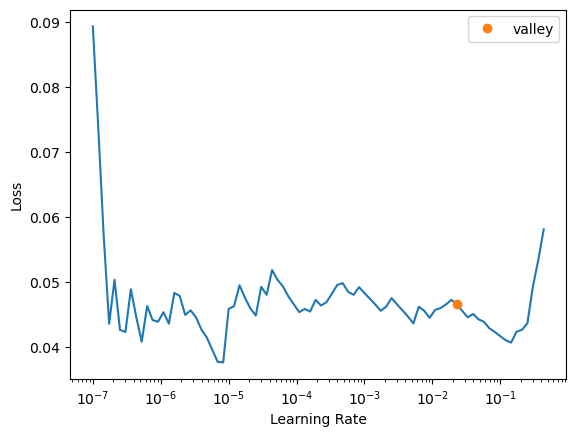

In [13]:
learn.lr_find()

In [14]:
#import torch.nn as nn
#Recommendations
def recommends(fav_movie, top_n=5):
    movie_factors = learn.model.movie_factors
    #we look up the movie in the movie factors
    idx = dls.classes['wine'].o2i[fav_movie]
    #find the movie with minimum distance
    distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])
    #we sort the movies by distance
    idx = distances.argsort(descending=True)[1:top_n+1]
    #we return the movies
    recommended_movies = [dls.classes['wine'][i] for i in idx]
    return recommended_movies

recommended_movies = recommends('Pinot Grigio')
print("Recommended movies:")
for movie in recommended_movies:
    print(movie)

Recommended movies:
Pinot Nero
Chateau coufran
Brachetto Piemonte
Daphne
nebbiolo


In [15]:
#def prediction for a user
def prediction_user_like(userId, title):
    userIdx = dls.classes['userId'].o2i[userId]
    movie_idx = dls.classes['wine'].o2i[title]

    # Make a prediction using the model's forward method
    prediction = learn.model.forward(tensor([[userIdx, movie_idx]])).item()

    return print(f"Predicted rating for user '{userId}' and '{title}': {prediction:.2f}")

prediction = prediction_user_like('13016d41-00bd-411c-83f5-2b95691696b7', 'chardonnay')
prediction = prediction_user_like(50, 'cabernet sauvignon')

Predicted rating for user '13016d41-00bd-411c-83f5-2b95691696b7' and 'chardonnay': 2.66
Predicted rating for user '50' and 'cabernet sauvignon': 2.74


In [16]:
# Show 20 rows of results
learn.show_results(n=20)

,userId,wine,rate,rate_pred
0,53,537,4,3.041690
1,148,172,2,2.003039
2,108,6,3,3.229543
3,74,541,4,3.393615
4,39,562,4,2.823670
5,143,379,2,2.424878
6,108,296,2,3.227713
7,143,7,1,1.002802
8,148,174,3,3.179161


In [17]:
g = df.groupby('wine')['rate'].count()
top_wines = g.sort_values(ascending=False).index.values[:50]
top_wines[:10]

array(['2/5 大亂鬥 2', 'Bread & Butter Pinor Noir 2020', 'Acinaia',
       'Cavalcaonte Barbera Forlí', 'Bella Cabernet Sauvignon',
       '19 crimes dark red', 'Cirus Madiran', '"PG Rosa" Pinot grigio',
       'Corvina ', 'Il Mattaglio Blanc de Blancs'], dtype=object)

In [18]:
from fastai.metrics import rmse

# Get predictions and targets
preds, targs = learn.get_preds()

# Calculate RMSE
error = rmse(preds, targs)
print(f'RMSE: {error}')

#MSE
error2 = mse(preds, targs)
print(f'MSE: {error2}')

#MAE
error3 = mae(preds, targs)
print(f'MAE: {error3}')

print(preds.shape)
print(targs.shape)

#transform the trags since they were a 2d tensor
targs = targs.squeeze()

#we create a dataframe with the predictions and the targets
df = pd.DataFrame({ 'targets': targs,'predictions': preds})
df.head(20)

#check the error
df['error'] = df['predictions'] - df['targets']


#print the error of the model
print(f"The error is : {df['error'].abs().mean()}")

df


RMSE: 0.7441595792770386
MSE: 0.5537735223770142
MAE: 0.42905741930007935
torch.Size([261])
torch.Size([261, 1])
The error is : 0.42905744910240173


,targets,predictions,error
0,4,2.641686,-1.358314
1,5,5.000732,0.000732
2,4,3.387666,-0.612334
3,2,1.997270,-0.002730
4,3,3.035611,0.035611
...,...,...,...
256,3,3.044462,0.044462
257,4,3.383171,-0.616829
258,5,5.052271,0.052271
259,2,1.972752,-0.027248


In [19]:
#sort by best predictions and worst predictions
#sort col error from 0 to 5(-5)

df['abs_error'] = df['error'].abs()
best_predictions = df.sort_values(by='abs_error', ascending=True)
worst_predictions = df.sort_values(by='error', ascending=False)

#best predictions
best_predictions.head(10)

,targets,predictions,error,abs_error
48,5,5.000732,0.000732,0.000732
26,5,5.000732,0.000732,0.000732
110,5,5.000732,0.000732,0.000732
207,5,5.000732,0.000732,0.000732
237,5,5.000732,0.000732,0.000732
127,5,5.000732,0.000732,0.000732
1,5,5.000732,0.000732,0.000732
202,5,5.000732,0.000732,0.000732
68,3,3.001404,0.001404,0.001404
246,1,1.001587,0.001587,0.001587


In [20]:
worst_predictions.head(10)

,targets,predictions,error,abs_error
189,1,3.209811,2.209811,2.209811
141,1,3.205956,2.205956,2.205956
120,1,2.448611,1.448611,1.448611
113,2,3.283210,1.283210,1.283210
250,2,3.227713,1.227713,1.227713
46,3,4.171263,1.171263,1.171263
58,3,4.032507,1.032507,1.032507
27,2,2.999911,0.999911,0.999911
57,2,2.979023,0.979023,0.979023
135,2,2.671556,0.671556,0.671556


In [21]:
def get_accuracy(df):
    # Count correct predictions
    correct = 0
    for _, row in df.iterrows():
        if round(row['predictions']) == round(row['targets']):
            correct += 1

    # Compute accuracy
    accuracy_percentage = correct / len(df)
    return accuracy_percentage * 100

# Get accuracy
accuracy = get_accuracy(df)
print(f'Accuracy: {accuracy:.2f}%')

Accuracy: 67.43%


In [22]:
preds, targs = learn.get_preds()

# Now you can check their shapes
print(f'Predictions shape: {preds.shape}')
print(f'Targets shape: {targs.shape}')

Predictions shape: torch.Size([261])
Targets shape: torch.Size([261, 1])


In [23]:
# Remove the extra dimension from targets
targs = targs.squeeze()

# Now the shapes should match
print(f'Predictions shape: {preds.shape}')
print(f'Targets shape: {targs.shape}')

Predictions shape: torch.Size([261])
Targets shape: torch.Size([261])


In [24]:
# Assuming `dls` is your DataLoader
for i, batch in enumerate(dls.valid):
    x, y = batch
    print(f'Batch {i+1}: {x.shape[0]}')

# Check the shape of predictions and targets
print(f'Predictions: {preds.shape[0]}')
print(f'Targets: {targs.shape[0]}')

Batch 1: 64
Batch 2: 64
Batch 3: 64
Batch 4: 64
Batch 5: 5
Predictions: 261
Targets: 261


In [25]:
print(f'Predictions: {preds.shape}')
print(f'Targets: {targs.shape}')

Predictions: torch.Size([261])
Targets: torch.Size([261])
